# Introduction to VAT

**++ Currently, the examples are being reworked after the latest update because GBIF behaves differently now. [Find out more](/updates/updates_and_changes.html). ++**

Welcome to geoengine-python! This notebook is intended to show you around and explain the basics of how geoengine-python and VAT are related.

The purpose of this notebook is to demonstrate the capabilities of Geo Engine. Therefore, some useful techniques will be shown: 

- Introduction to the geoengine-python package
- Loading a dataset
- Using operators
- Plotting the results
- First simple nested workflows
- The connection between Python and VAT

When building your own nested workflow, it is recommended to build it in several steps as seen in this notebook.

Documentation about the operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

The first thing to do is to import the geoengine-python package:

In [1]:
import geoengine as ge

For plotting it is currently also necessary to import Altair:

In [2]:
import altair as alt

In [3]:
#Other imports
from datetime import datetime
import matplotlib.pyplot as plt

To establish a connection with the VAT, the `ge.initialise` can be used together with the API URL:

In [4]:
ge.initialize("https://vat.gfbio.org/api")

In the case of a locally hosted instance, the link would be `http://localhost:4200/api`.

For a more comfortable work with the GBIF DataProvider it is possible to get the name from the `root_collection`:

In [5]:
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

To load data, use operators or plot vector data, 'workflows' need to be created, as shown in Loading the dragonfly species *Aeshna affinis*

## Load *Aeshna affinis* from the GBIF DataProvider

A workflow needs to be registered in the VAT or Geo Engine instance. Therefore, the command `ge.register_workflow` followed by the command in JSON can be used:

In [6]:
workflow_aeshna_affinis = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Aeshna affinis`",
        }
    }
})

workflow_aeshna_affinis

c7b6b25a-714d-58d1-9f53-db7bf4995a5b

Alternatively the `workflow_builder` can be used as shown here: TODO

The result of each registration is the workflow_id, which can be used directly in VAT to trigger the workflow. To finally load the vector data from VAT, the `.get_dataframe` method can be used. The method takes as parameters the search extent, a time interval, the spatial resolution and a coordinate reference system.

(-90.0, 90.0)

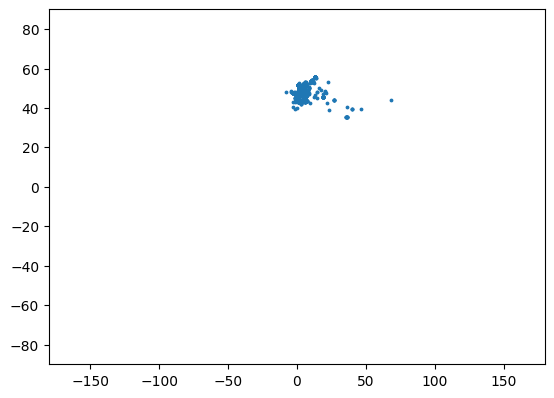

In [7]:
#Set time
start_time = datetime.strptime(
    '2010-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
end_time = datetime.strptime(
    '2011-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_aeshna_affinis.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
ax = data.plot(markersize=3)
ax.set_xlim([-180,180])
ax.set_ylim([-90,90])

The extent was chosen to make it clear that the occurrences of *Aeshna affinis* only occur on the Eurasian continent. Without the x- and y-limiters the plot would look different:

<Axes: >

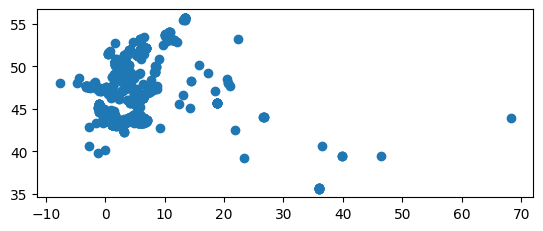

In [8]:
data.plot()

In addition to vector data, raster data could also be loaded from the VAT.

# Loading Minimum and Maximum temperature from the temperature collection

To load raster data again, a workflow must be registered, but this time the 'GdalSource' is used instead of the 'OgrSource':

In [9]:
workflow_t_min = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "RasterScaling",
        "params": {
            "slope": {
                "type": "constant",
                "value": 0.1
            },
            "offset": {
                "type": "constant",
                "value": -273.15
            },
            "outputMeasurement": {
                "type": "continuous",
                "measurement": "temperature",
                "unit": "K/10"
            },
            "scalingMode": "mulSlopeAddOffset"
        },
        "sources": {
            "raster": {
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "mean_daily_minimum_2m_air_temperature"
                        }
                    }
                }
            }
        }
    }
})

workflow_t_min

a57efb5a-7256-58b9-b9f2-9f22d9724bab

The raster data can then be requested as a `xarray.DataArray` and plotted that way:

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


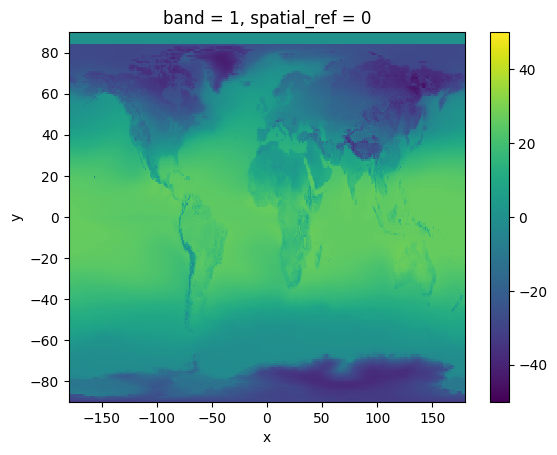

In [10]:
#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_min.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(1., 1.),
        srs="EPSG:4326"
    )
)

#Plot the data TODO more description
data.plot(vmin=-50, vmax=50)

The same can be done for the maximum temperature:

In [11]:
workflow_t_max = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "RasterScaling",
        "params": {
            "slope": {
                "type": "constant",
                "value": 0.1
            },
            "offset": {
                "type": "constant",
                "value": -273.15
            },
            "outputMeasurement": {
                "type": "continuous",
                "measurement": "temperature",
                "unit": "K/10"
            },
            "scalingMode": "mulSlopeAddOffset"
        },
        "sources": {
            "raster": {
                "type": "RasterTypeConversion",
                "params": {
                    "outputDataType": "F32"
                },
                "sources": {
                    "raster": {
                        "type": "GdalSource",
                        "params": {
                            "data": "mean_daily_maximum_2m_air_temperature"
                        }
                    }
                }
            }
        }        
    }
})

workflow_t_max

cdfe579d-b451-5b7e-b98d-bf0570489784

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


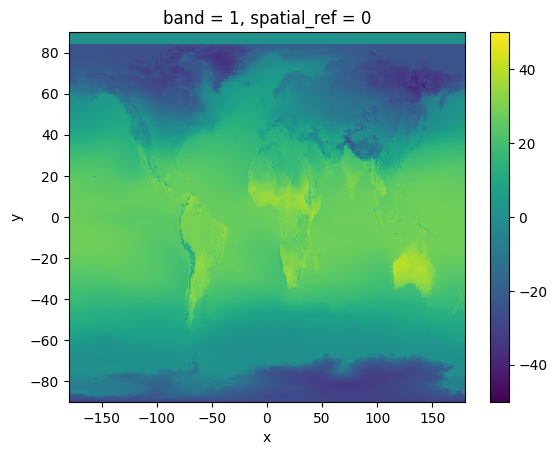

In [12]:
#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_max.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(1.0, 1.0),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-50, vmax=50)

As well as loading data, the VAT has several operators for manipulating or transforming geodata. One example is the raster vector join.

# Raster Vector Join between *Aeshna affinis* and the Minimum and Maximum Temperature

The raster vector join operator joins the vector data to one or more raster layers based on the position of the vector features. As shown in this example, the inputs are more or less the individual workflows seen before:

In [13]:
workflow_aeshna_affinis_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Min_Temperature", "Max_Temperature"]
            },
            "temporalAggregation": "none",
            "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Aeshna affinis ##########################################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Aeshna affinis`",
                }
            }, ###################################################################
            "rasters": [{ #Minimum temperature ###################################
                    "type": "RasterScaling",
                    "params": {
                        "slope": {
                            "type": "constant",
                            "value": 0.1
                        },
                        "offset": {
                            "type": "constant",
                            "value": -273.15
                        },
                        "outputMeasurement": {
                            "type": "continuous",
                            "measurement": "temperature",
                            "unit": "K/10"
                        },
                        "scalingMode": "mulSlopeAddOffset"
                    },
                    "sources": {
                        "raster": {
                            "type": "RasterTypeConversion",
                            "params": {
                                "outputDataType": "F32"
                            },
                            "sources": {
                                "raster": {
                                    "type": "GdalSource",
                                    "params": {
                                        "data": "mean_daily_minimum_2m_air_temperature"
                                    }
                                }
                            }
                        }
                    }
                }, ################################################################ 
                { #Maximum temperature ############################################
                    "type": "RasterScaling",
                    "params": {
                        "slope": {
                            "type": "constant",
                            "value": 0.1
                        },
                        "offset": {
                            "type": "constant",
                            "value": -273.15
                        },
                        "outputMeasurement": {
                            "type": "continuous",
                            "measurement": "temperature",
                            "unit": "K/10"
                        },
                        "scalingMode": "mulSlopeAddOffset"
                    },
                    "sources": {
                        "raster": {
                            "type": "RasterTypeConversion",
                            "params": {
                                "outputDataType": "F32"
                            },
                            "sources": {
                                "raster": {
                                    "type": "GdalSource",
                                    "params": {
                                        "data": "mean_daily_maximum_2m_air_temperature"
                                    }
                                }
                            }
                        }
                    }
                } #################################################################
            ]
        }
    }
})
    

workflow_aeshna_affinis_join

8b26f457-4d52-5f35-b10a-aca7352f47d1

The input parameters required for each operator can be found in the documentation: https://docs.geoengine.io/operators/intro.html. In this example, the RasterVectorJoin operator takes two input parameters: vector, which represents the vector layer to use, and raster, which represents the one or more raster layers to join.

The resulting vector data again can be retrieved by requesting the data as a GeoDataFrame:

In [14]:
#Request the data from Geo Engine into a geopandas dataframe
data_aeshna_affinis = workflow_aeshna_affinis_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data_aeshna_affinis

,geometry,Max_Temperature,Min_Temperature,basisofrecord,gbifid,scientificname,start,end
0,POINT (6.17690 52.27207),13.250000,4.350006,HUMAN_OBSERVATION,699741184,"Aeshna affinis Vander Linden, 1820",2010-04-28 00:00:00+00:00,2010-04-28 00:00:00+00:00
1,POINT (6.17690 52.27207),13.250000,4.350006,HUMAN_OBSERVATION,699741183,"Aeshna affinis Vander Linden, 1820",2010-04-28 00:00:00+00:00,2010-04-28 00:00:00+00:00
2,POINT (3.55448 43.39541),18.550018,13.850006,HUMAN_OBSERVATION,3945130371,"Aeshna affinis Vander Linden, 1820",2010-05-26 00:00:00+00:00,2010-05-26 00:00:00+00:00
3,POINT (3.76048 49.60182),17.550018,8.750000,HUMAN_OBSERVATION,2485531094,"Aeschna affinis Stephens, 1836",2010-05-25 00:00:00+00:00,2010-05-25 00:00:00+00:00
4,POINT (3.76048 49.60182),17.550018,8.750000,HUMAN_OBSERVATION,2485629036,"Aeschna affinis Stephens, 1836",2010-05-28 00:00:00+00:00,2010-05-28 00:00:00+00:00
...,...,...,...,...,...,...,...,...
973,POINT (5.94470 46.68733),NaN,NaN,HUMAN_OBSERVATION,3480458996,"Aeshna affinis Vander Linden, 1820",2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
974,POINT (2.73627 49.70645),NaN,NaN,HUMAN_OBSERVATION,3845267165,"Aeshna affinis Vander Linden, 1820",2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
975,POINT (2.62640 49.08975),NaN,NaN,HUMAN_OBSERVATION,3072870148,"Aeshna affinis Vander Linden, 1820",2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
976,POINT (3.79175 46.02396),NaN,NaN,HUMAN_OBSERVATION,3072950291,"Aeshna affinis Vander Linden, 1820",2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00


The data could then be plotted directly in Python:

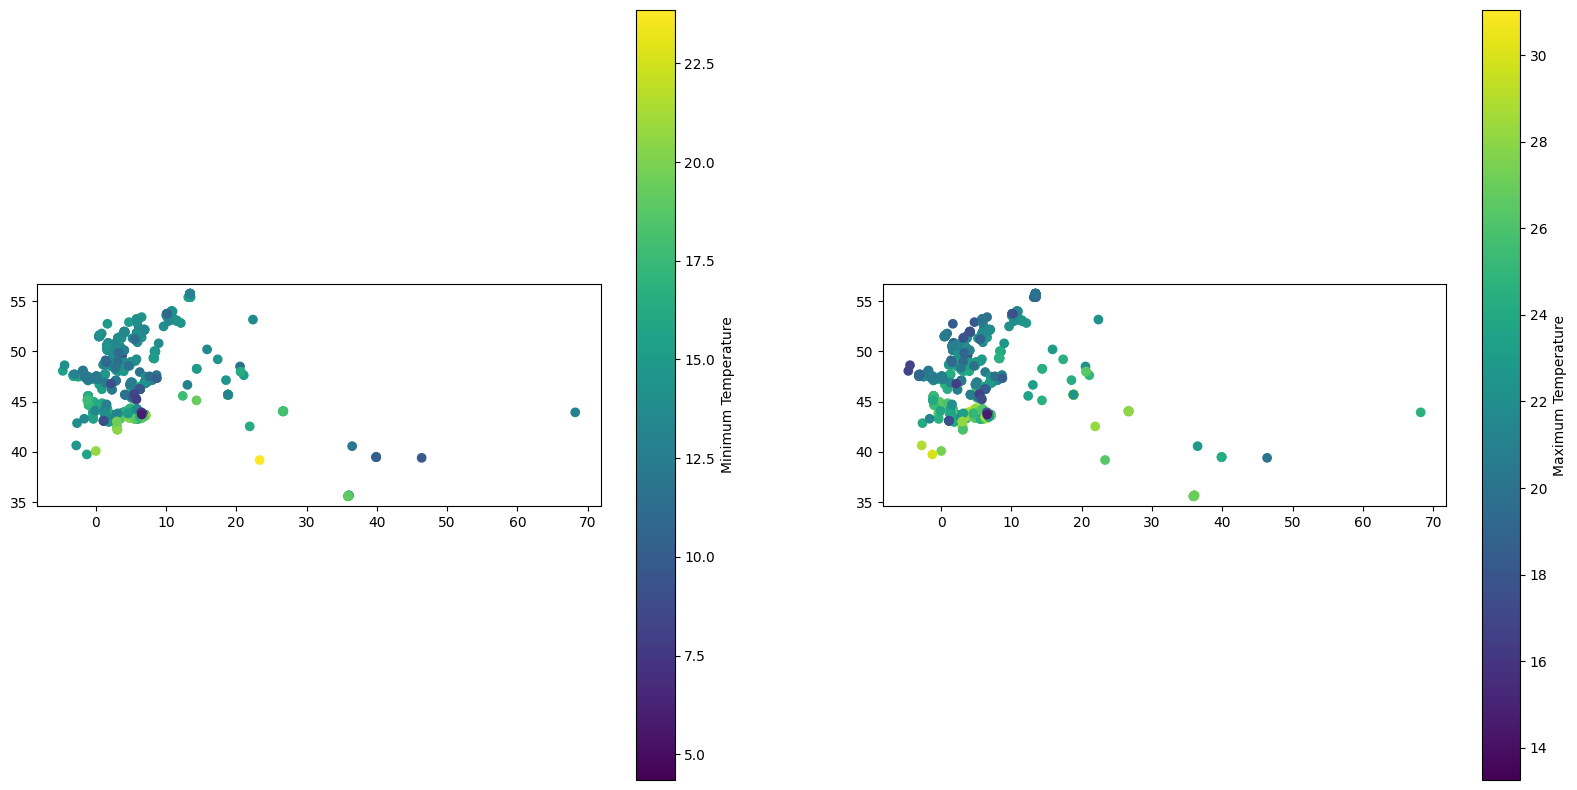

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

data_aeshna_affinis.plot(ax=ax[0], column='Min_Temperature', legend=True, legend_kwds={'label': 'Minimum Temperature'})
data_aeshna_affinis.plot(ax=ax[1], column='Max_Temperature', legend=True, legend_kwds={'label': 'Maximum Temperature'})

plt.show()

The VAT also offers some of its own plot types, such as histograms.

# Plotting *Aeshna affinis* Minimum and Maximum Temperature as Histograms using VAT

Of course, a workflow must be registered in order to plot the data:

In [16]:
workflow_aeshna_affinis_join_plot_min = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "Histogram",
       "params": {
          "attributeName": "Min_Temperature",
           "bounds": "data",
           "buckets": {
               "type": "number",
               "value": 20
           }
       },
        "sources": {
            "source": { #Aeshna affinis Join #############################################
                "type": "RasterVectorJoin",
                "params": {
                    "names": {
                        "type": "names",
                        "values": ["Min_Temperature", "Max_Temperature"]
                    },
                    "temporalAggregation": "none",
                    "featureAggregation": "mean",
                },
                "sources": {
                    "vector": { 
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Aeshna affinis`",
                        }
                    }, 
                    "rasters": [{
                            "type": "RasterScaling",
                            "params": {
                                "slope": {
                                    "type": "constant",
                                    "value": 0.1
                                },
                                "offset": {
                                    "type": "constant",
                                    "value": -273.15
                                },
                                "outputMeasurement": {
                                    "type": "continuous",
                                    "measurement": "temperature",
                                    "unit": "K/10"
                                },
                                "scalingMode": "mulSlopeAddOffset"
                            },
                            "sources": {
                                "raster": {
                                    "type": "RasterTypeConversion",
                                    "params": {
                                        "outputDataType": "F32"
                                    },
                                    "sources": {
                                        "raster": {
                                            "type": "GdalSource",
                                            "params": {
                                                "data": "mean_daily_minimum_2m_air_temperature"
                                            }
                                        }
                                    }
                                }
                            }
                        }, 
                        {
                            "type": "RasterScaling",
                            "params": {
                                "slope": {
                                    "type": "constant",
                                    "value": 0.1
                                },
                                "offset": {
                                    "type": "constant",
                                    "value": -273.15
                                },
                                "outputMeasurement": {
                                    "type": "continuous",
                                    "measurement": "temperature",
                                    "unit": "K/10"
                                },
                                "scalingMode": "mulSlopeAddOffset"
                            },
                            "sources": {
                                "raster": {
                                    "type": "RasterTypeConversion",
                                    "params": {
                                        "outputDataType": "F32"
                                    },
                                    "sources": {
                                        "raster": {
                                            "type": "GdalSource",
                                            "params": {
                                                "data": "mean_daily_maximum_2m_air_temperature"
                                            }
                                        }
                                    }
                                }
                            }
                        } 
                    ]
                } ##########################################################################
            } 
       }
    }
})
    
workflow_aeshna_affinis_join_plot_min

8426078a-2940-5a76-8f16-afda4ed45b80

The `.plot_chart` method can be used to get the plot, which can then be plotted using the `altair`' package:

In [17]:
#Request the plot from Geo Engine
plot_aeshna_affinis_min = workflow_aeshna_affinis_join_plot_min.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_aeshna_affinis_min.spec)

alt.Chart(...)

The same can be done for the maximum temperature:

In [18]:
workflow_aeshna_affinis_join_plot_max = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "Histogram",
       "params": {
          "attributeName": "Max_Temperature",
           "bounds": "data",
           "buckets": {
               "type": "number",
               "value": 20
           }
       },
        "sources": {
            "source": { #Aeshna affinis Join #############################################
                "type": "RasterVectorJoin",
                "params": {
                    "names": {
                        "type": "names",
                        "values": ["Min_Temperature", "Max_Temperature"]
                    },
                    "temporalAggregation": "none",
                    "featureAggregation": "mean",
                },
                "sources": {
                    "vector": { 
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Aeshna affinis`",
                        }
                    }, 
                    "rasters": [{
                            "type": "RasterScaling",
                            "params": {
                                "slope": {
                                    "type": "constant",
                                    "value": 0.1
                                },
                                "offset": {
                                    "type": "constant",
                                    "value": -273.15
                                },
                                "outputMeasurement": {
                                    "type": "continuous",
                                    "measurement": "temperature",
                                    "unit": "K/10"
                                },
                                "scalingMode": "mulSlopeAddOffset"
                            },
                            "sources": {
                                "raster": {
                                    "type": "RasterTypeConversion",
                                    "params": {
                                        "outputDataType": "F32"
                                    },
                                    "sources": {
                                        "raster": {
                                            "type": "GdalSource",
                                            "params": {
                                                "data": "mean_daily_minimum_2m_air_temperature"
                                            }
                                        }
                                    }
                                }
                            }
                        }, 
                        {
                            "type": "RasterScaling",
                            "params": {
                                "slope": {
                                    "type": "constant",
                                    "value": 0.1
                                },
                                "offset": {
                                    "type": "constant",
                                    "value": -273.15
                                },
                                "outputMeasurement": {
                                    "type": "continuous",
                                    "measurement": "temperature",
                                    "unit": "K/10"
                                },
                                "scalingMode": "mulSlopeAddOffset"
                            },
                            "sources": {
                                "raster": {
                                    "type": "RasterTypeConversion",
                                    "params": {
                                        "outputDataType": "F32"
                                    },
                                    "sources": {
                                        "raster": {
                                            "type": "GdalSource",
                                            "params": {
                                                "data": "mean_daily_maximum_2m_air_temperature"
                                            }
                                        }
                                    }
                                }
                            }
                        } 
                    ]
                } ##########################################################################
            } 
       }
    }
})

#Request the plot from Geo Engine
plot_aeshna_affinis_max = workflow_aeshna_affinis_join_plot_max.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180, -90, 180, 90),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_aeshna_affinis_max.spec)

alt.Chart(...)

As you can see, VAT offers a lot of functionality, which will be deepened and extended in the following examples.

# Further experiments

In this chapter, some other useful links between Geo Engine and Python are shown.

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa
/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


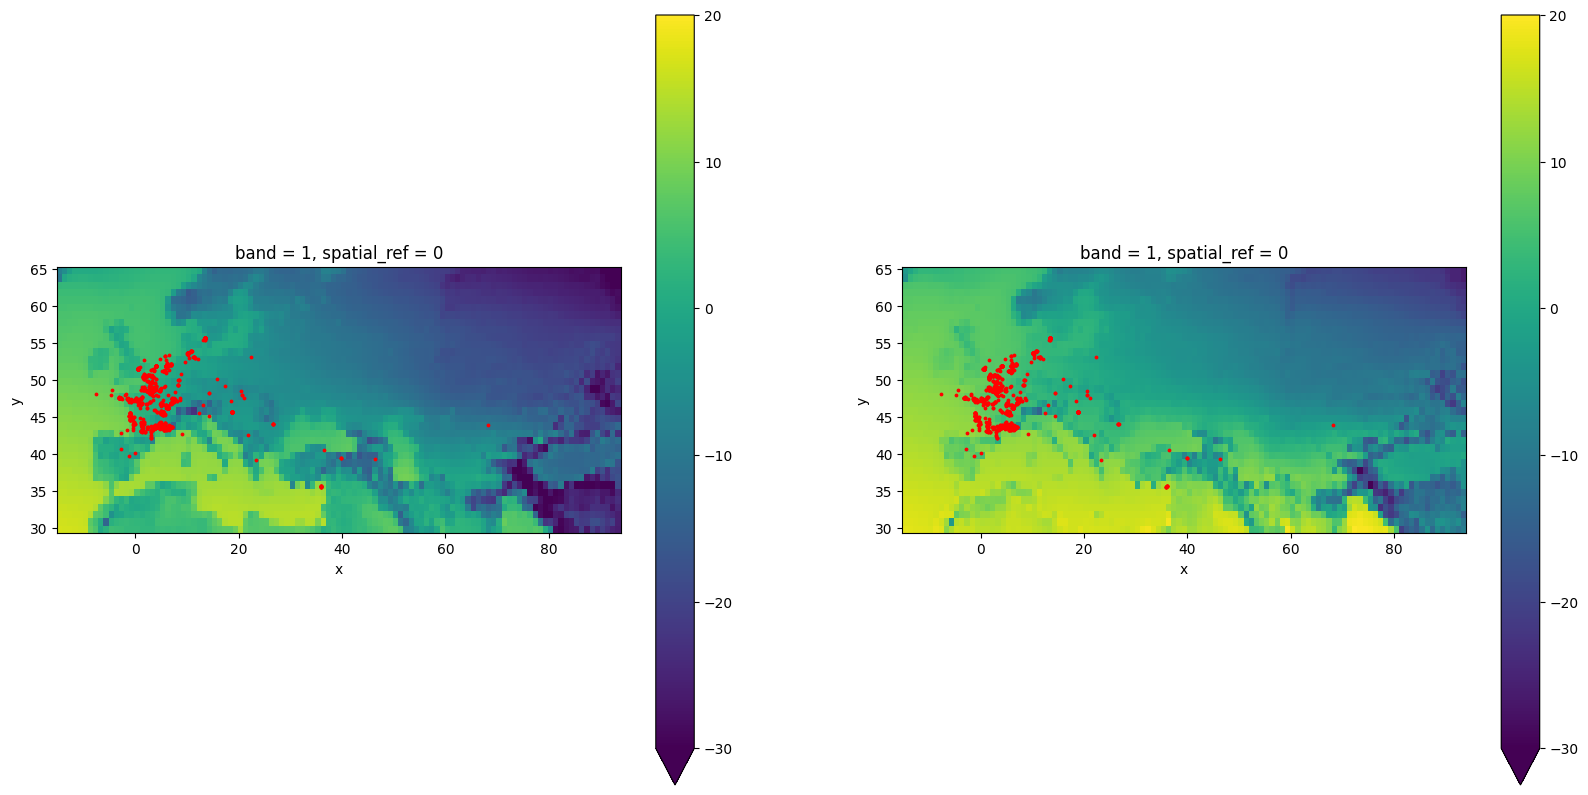

In [19]:
#Overlay plot with context
import geopandas as gpd
import matplotlib.pyplot as plt

#Request the data from Geo Engine into a xarray dataarray
data_min = workflow_t_min.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-15.1189, 29.6655, 92.9116, 65.3164),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(1.0, 1.0),
        srs="EPSG:4326"
    )
)

#Request the data from Geo Engine into a xarray dataarray
data_max = workflow_t_max.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-15.1189, 29.6655, 92.9116, 65.3164),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(1.0, 1.0),
        srs="EPSG:4326"
    )
)


#Plot the data
fig, ax = plt.subplots(1, 2, figsize=(20,10))

data_min.plot(ax=ax[0], vmin=-30, vmax=20)
data_aeshna_affinis.plot(ax=ax[0], color='red', markersize=3)

data_max.plot(ax=ax[1], vmin=-30, vmax=20)
data_aeshna_affinis.plot(ax=ax[1], color='red', markersize=3)

plt.show()